# Project: Hungarian Chickenpox Cases Forecasting

Abstract: A spatio-temporal dataset of weekly chickenpox cases from Hungary. The dataset consists of a county-level adjacency matrix and time series of the county-level reported cases between 2005 and 2015.

# About the datases:

link to hte dataset at UCI: https://archive.ics.uci.edu/ml/datasets/Hungarian+Chickenpox+Cases

Data Set Characteristics: Time-Series

Number of Instances: 521

Area: Life

Attribute Characteristics: Real

Number of Attributes: 20

Date Donated 2021-02-17

Associated Tasks: Regression

Missing Values? N/A

Number of Web Hits: 24976

## Source:

Benedek Rozemberczki, The University of Edinburgh, benedek.rozemberczki '@' gmail.com

## Data Set Information:

A spatio-temporal dataset of weekly chickenpox (childhood disease) cases from Hungary. The dataset consists of a county-level adjacency matrix and time series of the county-level reported cases between 2005 and 2015. There are 2 specific related tasks: County level case count prediction and nation level case count prediction.

## Attribute Information:

Attributes are weekly counts of chickenpox cases in Hungarian counties.


## Relevant Papers:

Chickenpox Cases in Hungary: a Benchmark Dataset for Spatiotemporal Signal Processing with Graph Neural Networks
Benedek Rozemberczki, Paul Scherer, Oliver Kiss, Rik Sarkar, Tamas Ferenci



## Citation Request:

@misc{rozemberczki2021chickenpox,
title={Chickenpox Cases in Hungary: a Benchmark Dataset for Spatiotemporal Signal Processing with Graph Neural Networks},
author={Benedek Rozemberczki and Paul Scherer and Oliver Kiss and Rik Sarkar and Tamas Ferenci},
year={2021},
eprint={2102.08100},
archivePrefix={arXiv},
primaryClass={cs.SI}
}

# County-wide cases prediction

## STEP 1: Learning the dataset and feature engineering

In [1]:
# importing libraries
# for working with arrays and dataframes
import numpy as np
import pandas as pd

# for plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import scipy.stats as stats # for Q-Q plots

In [2]:
df = pd.read_csv("hungary_chickenpox.csv")

In [3]:
# df.head

In [4]:
# setting "Date" to be the index
df.set_index('Date',inplace=True)
df.index.freq = 'W'
df.index = pd.to_datetime(df.index, format='%d/%m/%Y')

In [5]:
# showing the dateset
# df.head()

In [6]:
# showing an information about the dataset
# df.info()

In [7]:
# showing statistical information about the dataset
# df.describe()

In [8]:
# summing up all the columns
df['Total_Cases'] = df.iloc[:, 1:].sum(axis = 1, skipna = True)

In [9]:
# showing the dateset
# df.head()

### Plotting the series

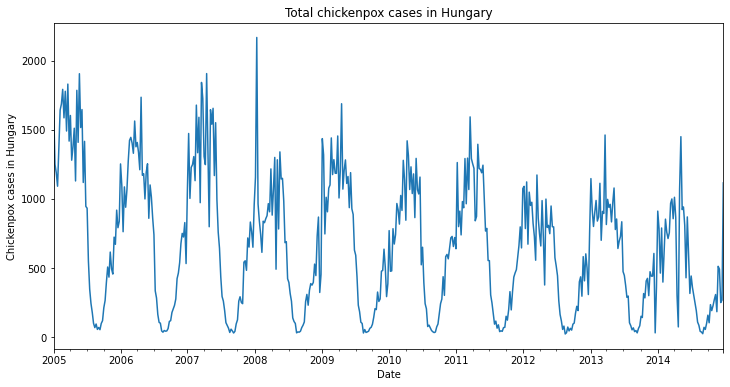

In [10]:
title = 'Total chickenpox cases in Hungary'
ylabel = 'Chickenpox cases in Hungary'
xlabel = 'Date'

ax = df['Total_Cases'].plot(figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

Discussion: downward trend and annual oscillations have been observed.

### Treating outliers

Resampling the data with monthly frequency

In [11]:
df = df.resample('M').mean()

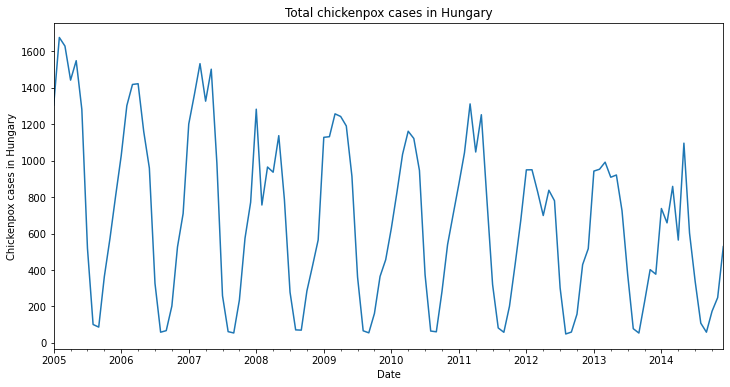

In [12]:
title = 'Total chickenpox cases in Hungary'
ylabel = 'Chickenpox cases in Hungary'
xlabel = 'Date'

ax = df['Total_Cases'].plot(figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

## STEP 2: Analyzing the time series and predicting with SARIMA

### SARIMA optimized with autoARIMA

In [13]:
# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

### Running ETS decomposition

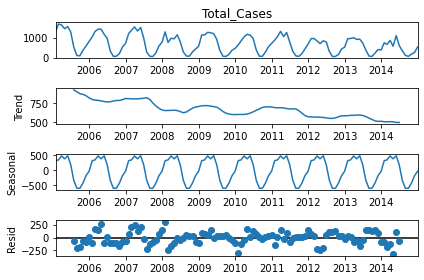

In [14]:
# decomposing the series to trend, seasonal and residual and then plotting them
result = seasonal_decompose(df['Total_Cases'], model='add')
result.plot();

### Runing pmdarima.auto_arima to obtain recommended orders

Discussion: the decomposition shows a prominent seasonal component and an unclear trend.

In [15]:
# for SARIMA orders setting seasonal=True and pass in an m value
auto_arima(df['Total_Cases'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  120
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -772.524
Date:                              Tue, 27 Jul 2021   AIC                           1555.049
Time:                                      13:45:20   BIC                           1568.986
Sample:                                           0   HQIC                          1560.709
                                              - 120                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.2172      5.183      1.007      0.314      -4.941      15.375
ar.L1          0.6668      0.074      9.038      0.000       0.522       0.811
ar.S.L12       0.9776      0.017     56.350      0.000       0.944       1.012
ma.S.L12      -0.6130      0.143     -4.277      0.000      -0.894      -0.332
sigma2      1.893e+04   1435.883     13.185      0.000    1.61e+04    2.17e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.65   Jarque-Bera (JB):               109.50
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                            -0.97
Prob(H) (two-sided):                  0.03   Kurtosis:                         7.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

This provides an ARIMA Order of (1,0,0) combined with a seasonal order of (1,0,1,12) Now let's train & test the SARIMA(1,0,0)(1,0,1,12) model, evaluate it, then produce a forecast of future values.

### Splitting the data into train/test sets

In [16]:
len(df)

120

In [17]:
# setting one year for testing
train = df.iloc[:109]
test = df.iloc[109:]

In [18]:
# fitting SARIMA(1,0,0)(1,0,1,12) model
model = SARIMAX(train['Total_Cases'],order=(1,0,0),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                          Total_Cases   No. Observations:                  109
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -701.673
Date:                              Tue, 27 Jul 2021   AIC                           1411.347
Time:                                      13:45:21   BIC                           1422.112
Sample:                                  01-31-2005   HQIC                          1415.713
                                       - 01-31-2014                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7908      0.043     18.262      0.000       0.706       0.876
ar.S.L12       0.9925      0.010     95.191      0.000       0.972       1.013
ma.S.L12      -0.7415      0.176     -4.220      0.000      -1.086      -0.397
sigma2       1.75e+04   1493.187     11.722      0.000    1.46e+04    2.04e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.61   Jarque-Bera (JB):               207.43
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                            -1.35
Prob(H) (two-sided):                  0.17   Kurtosis:                         9.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
# obtaining predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1,0,0)(1,0,1,12) Predictions')

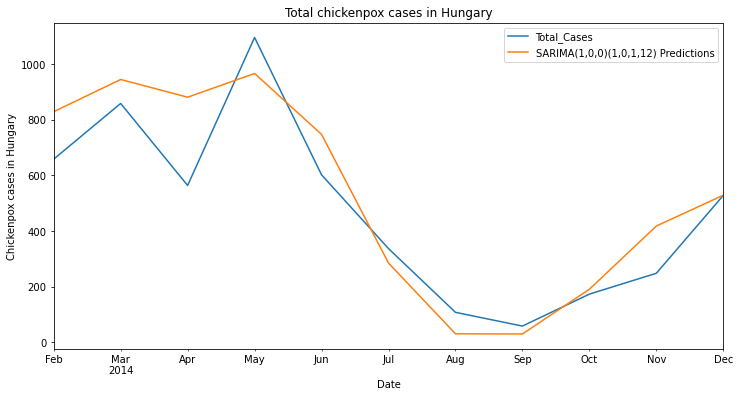

In [20]:
# plotting predictions against known values
title = 'Total chickenpox cases in Hungary'
ylabel = 'Chickenpox cases in Hungary'
xlabel = 'Date'

ax = test['Total_Cases'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### Evaluating the model

In [21]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['Total_Cases'], predictions)
print(f'SARIMA(1,0,0)(1,0,1,12) RMSE Error: {error:11.10}')

SARIMA(1,0,0)(1,0,1,12) RMSE Error: 139.3851334


Discussion: the high prediction errors might be explained by the fact that the predicted year differs from two previous by two spikes, downward-facing and upward-facing, in April and May 2014.

### Retraining the model on the full data, and forecasting the future

In [22]:
model = SARIMAX(df['Total_Cases'],order=(1,0,0),seasonal_order=(1,0,1,12))
results = model.fit()
fcast = results.predict(len(df),len(df)+11,typ='levels').rename('SARIMA(1,0,0)(1,0,1,12) Forecast')

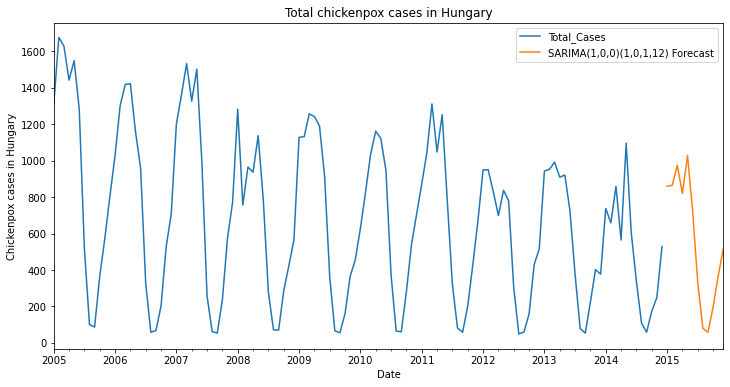

In [23]:
# plotting predictions against known values
title = 'Total chickenpox cases in Hungary'
ylabel = 'Chickenpox cases in Hungary'
xlabel = 'Date'

ax = df['Total_Cases'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

#### Summary: SARIMA(1,0,0)(1,0,1,12) has reasonably repeated the time series pattern after interpolating from weekly to monthly sampling.

## STEP 3: Predicting with LSTM RNN

# First, predicting the test set

### Scale the data

In [24]:
# importing MinMax scaler
from sklearn.preprocessing import MinMaxScaler

In [25]:
# defining a scaler
scaler = MinMaxScaler()

In [26]:
# train

In [27]:
train.columns

Index(['BUDAPEST', 'BARANYA', 'BACS', 'BEKES', 'BORSOD', 'CSONGRAD', 'FEJER',
       'GYOR', 'HAJDU', 'HEVES', 'JASZ', 'KOMAROM', 'NOGRAD', 'PEST', 'SOMOGY',
       'SZABOLCS', 'TOLNA', 'VAS', 'VESZPREM', 'ZALA', 'Total_Cases'],
      dtype='object')

In [28]:
# creating train_total and test_total datasets only with "Total_Cases" column
columns_to_drop = ['BUDAPEST', 'BARANYA', 'BACS', 'BEKES', 'BORSOD', 'CSONGRAD', 'FEJER',
       'GYOR', 'HAJDU', 'HEVES', 'JASZ', 'KOMAROM', 'NOGRAD', 'PEST', 'SOMOGY',
       'SZABOLCS', 'TOLNA', 'VAS', 'VESZPREM', 'ZALA']
train_total = train.drop(columns_to_drop, axis = 1)
test_total = test.drop(columns_to_drop, axis = 1)
# train_total
# test_total

In [29]:
# fitting the scaler
scaler.fit(train_total)

MinMaxScaler()

In [30]:
# scaling the series
scaled_train = scaler.transform(train_total)
scaled_test = scaler.transform(test_total)

### Time series senerator

In [31]:
# importing a generator
from keras.preprocessing.sequence import TimeseriesGenerator

In [32]:
# defining time series generator with 12 steps forwqrd generating
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [33]:
# calculating first batch
# X,y = generator[0]

In [34]:
# printing the first batch and first month prediction
# print(f'Given the Array: \n{X.flatten()}')
# print(f'Predict this y: \n {y}')

### Building a model

In [35]:
# importing the libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [36]:
# defining the model
n_features = 1   # for single time series
model = Sequential()
model.add(LSTM(576, activation='relu', input_shape=(n_input, n_features)))
# model.add(Dense(144, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [37]:
# model.summary()

In [38]:
# fitting the model
model.fit_generator(generator,epochs=50)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
97/97 [==============================] - 3s 31ms/step - loss: 0.0530
Epoch 2/50
97/97 [==============================] - 3s 31ms/step - loss: 0.0245
Epoch 3/50
97/97 [==============================] - 3s 32ms/step - loss: 0.0350
Epoch 4/50
97/97 [==============================] - 3s 31ms/step - loss: 0.0135
Epoch 5/50
97/97 [==============================] - 3s 31ms/step - loss: 0.0141
Epoch 6/50
97/97 [==============================] - 3s 31ms/step - loss: 0.0132
Epoch 7/50
97/97 [==============================] - 3s 31ms/step - loss: 0.0132
Epoch 8/50
97/97 [==============================] - 3s 31ms/step - loss: 0.0123
Epoch 9/50
97/97 [==============================] - 3s 31ms/step - loss: 0.0142
Epoch 10/50
97/97 [==============================] - 3s 31ms/step - loss: 0.0161
Epoch 11/50
97/97 [==============================] - 3s 31ms/step - loss: 0.0117
Epoch 12/50
97/97 [=======================

In [39]:
#showing the convergence log columns
model.history.history.keys()

dict_keys(['loss'])

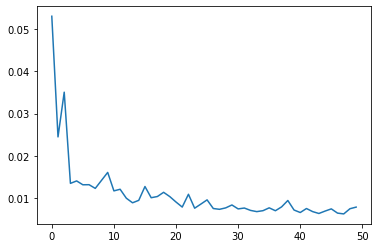

In [40]:
# printing the convergence log
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch);

### Evaluating the test data

In [41]:
# first batch
first_eval_batch = scaled_train[-12:]

In [42]:
# first_eval_batch

In [43]:
# reshaping the first batch
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [44]:
# first_eval_batch

In [45]:
# predicting first vaue of the test series
model.predict(first_eval_batch)

array([[0.5119544]], dtype=float32)

In [46]:
scaled_test[0]

array([0.37475042])

Predicting into the future for the entire test range

In [47]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [48]:
current_batch.shape

(1, 12, 1)

In [49]:
current_batch

array([[[0.55552143],
        [0.57948088],
        [0.52861312],
        [0.53616956],
        [0.41560436],
        [0.20165873],
        [0.017816  ],
        [0.00310244],
        [0.10766395],
        [0.21701736],
        [0.20165873],
        [0.42313009]]])

In [50]:
np.append(current_batch[:,1:,:],[[[99]]],axis=1)

array([[[5.79480879e-01],
        [5.28613116e-01],
        [5.36169559e-01],
        [4.15604362e-01],
        [2.01658731e-01],
        [1.78160037e-02],
        [3.10244202e-03],
        [1.07663953e-01],
        [2.17017355e-01],
        [2.01658731e-01],
        [4.23130088e-01],
        [9.90000000e+01]]])

In [51]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # getting a prediction 1 time stamp ahead ([0] is for taking one number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # storing the prediction
    test_predictions.append(current_pred) 
    
    # updating batch by including prediction and dropping a first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [52]:
# test_predictions

In [53]:
# scaled_test

### Making inverse transformations and comparing

In [54]:
# inverse transformation
true_predictions = scaler.inverse_transform(test_predictions)

In [55]:
# true_predictions

In [56]:
# test_total

In [57]:
# adding "Predictions" column to test_total
test_total['LSTM Predictions'] = true_predictions

In [58]:
# test_total

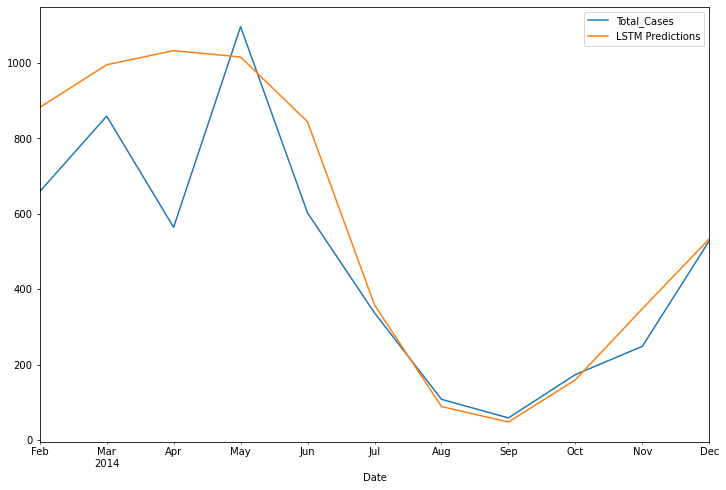

In [59]:
# plotting y & y_hat
test_total.plot(figsize=(12,8));

### Evaluating the model

In [60]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test_total['Total_Cases'], test_total['LSTM Predictions'])
print(f'SARIMA(1,0,0)(1,0,1,12) RMSE Error: {error:11.10}')

SARIMA(1,0,0)(1,0,1,12) RMSE Error:  181.857892


Discussion: LSTM error is sensible higher than SARIMA error. This might be because of the fact LSTM did not reflect abrupt fluctuations.

# Second, predicting one year forward

In [61]:
# creating df_total dataset only with "Total_Cases" column
df_total = df.drop(columns_to_drop, axis = 1)
# df_total

In [62]:
# fitting the scaler
scaler.fit(df_total)

MinMaxScaler()

In [63]:
# scaling the series
scaled_df_total = scaler.transform(df_total)

### Time series generator

In [64]:
# defining time series generator with 12 steps forwqrd generating
n_input = 12
generator = TimeseriesGenerator(scaled_df_total, scaled_df_total, length=n_input, batch_size=1)

In [65]:
# calculating first batch
# X,y = generator[0]

In [66]:
# printing the first batch and first month prediction
# print(f'Given the Array: \n{X.flatten()}')
# print(f'Predict this y: \n {y}')

### Building a model

In [67]:
# defining the model
n_features = 1   # for single time series
model = Sequential()
model.add(LSTM(576, activation='relu', input_shape=(n_input, n_features)))
# model.add(Dense(144, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [68]:
# model.summary()

In [69]:
# fitting the model
model.fit_generator(generator,epochs=50)

Epoch 1/50
108/108 [==============================] - 3s 31ms/step - loss: 0.0539
Epoch 2/50
108/108 [==============================] - 3s 32ms/step - loss: 0.0332
Epoch 3/50
108/108 [==============================] - 3s 32ms/step - loss: 0.0199
Epoch 4/50
108/108 [==============================] - 4s 34ms/step - loss: 0.0162
Epoch 5/50
108/108 [==============================] - 4s 36ms/step - loss: 0.0150
Epoch 6/50
108/108 [==============================] - 4s 35ms/step - loss: 0.0150
Epoch 7/50
108/108 [==============================] - 4s 36ms/step - loss: 0.0118
Epoch 8/50
108/108 [==============================] - 4s 36ms/step - loss: 0.0149
Epoch 9/50
108/108 [==============================] - 4s 34ms/step - loss: 0.0142
Epoch 10/50
108/108 [==============================] - 4s 34ms/step - loss: 0.0118
Epoch 11/50
108/108 [==============================] - 3s 32ms/step - loss: 0.0130
Epoch 12/50
108/108 [==============================] - 4s 34ms/step - loss: 0.0113
Epoch 13/50
1

In [70]:
#showing the convergence log columns
model.history.history.keys()

dict_keys(['loss'])

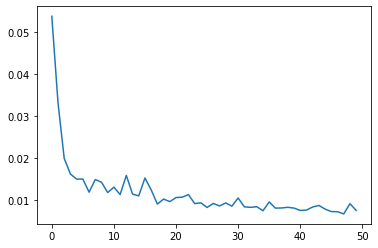

In [71]:
# printing the convergence log
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch);

### Saving and loading the model

In [72]:
model.save('my_rnn_model.h5')

In [73]:
from keras.models import load_model
new_model = load_model('my_rnn_model.h5')

In [74]:
# new_model.summary()

### Predicting 12 steps forward

In [75]:
# first batch
first_eval_batch = scaled_df_total[-12:]

In [76]:
# first_eval_batch

In [77]:
# reshaping the first batch
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [78]:
# first_eval_batch

Predicting into the future for the entire test range

In [79]:
test_predictions = []

first_eval_batch = scaled_df_total[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [80]:
# current_batch.shape

In [81]:
# current_batch

In [82]:
np.append(current_batch[:,1:,:],[[[99]]],axis=1)

array([[[3.74750422e-01],
        [4.97773000e-01],
        [3.16694824e-01],
        [6.43526340e-01],
        [3.40132084e-01],
        [1.77238519e-01],
        [3.63999386e-02],
        [6.05129780e-03],
        [7.66395331e-02],
        [1.22715405e-01],
        [2.94670558e-01],
        [9.90000000e+01]]])

In [83]:
lstm_predictions = []

first_eval_batch = scaled_df_total[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # getting a prediction 1 time stamp ahead ([0] is for taking one number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # storing the prediction
    lstm_predictions.append(current_pred) 
    
    # updating batch by including prediction and dropping a first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [84]:
# lstm_predictions

### Making inverse transformations and plotting the result

In [85]:
# inverse transformation
lstm_predictions = scaler.inverse_transform(lstm_predictions)

In [86]:
# lstm_predictions

In [87]:
# lstm_predictions.shape

In [88]:
# writting all the forecasts in single data frame
index = fcast.index[:-1]
fcast_2 = pd.DataFrame(data=lstm_predictions,columns=['LSTM Forecast'],index=index)
fcast_2['SARIMA(1,0,0)(1,0,1,12) Forecast'] = fcast

In [89]:
# fcast_2

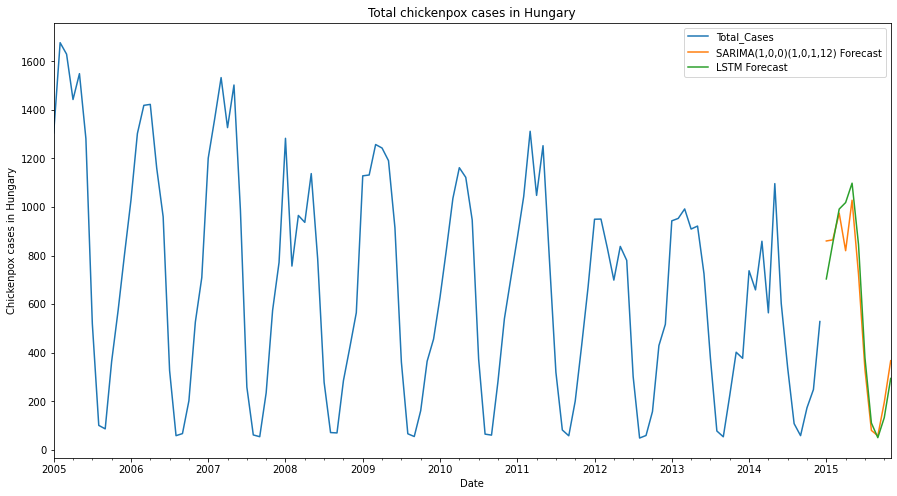

In [90]:
# plotting predictions against known values
title = 'Total chickenpox cases in Hungary'
ylabel = 'Chickenpox cases in Hungary'
xlabel = 'Date'

ax = df['Total_Cases'].plot(legend=True,figsize=(15,8),title=title)
fcast_2['SARIMA(1,0,0)(1,0,1,12) Forecast'].plot(legend=True)
fcast_2['LSTM Forecast'].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### Discussion: SARIMA and LSTM RNN has demonstrared similar performance.